# Set Task Config and Read CSV file

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

info_type = "hidden_states"
layer = "31"
file_name = "rq23_all_settings.csv"

humaneval_file_path = os.path.join(
    "humaneval", "codellama-7b-Python", info_type, layer, file_name
)
mbpp_file_path = os.path.join(
    "mbpp", "codellama-7b-Python", info_type, layer, file_name
)
code_search_net_java_file_path = os.path.join(
    "code_search_net_java",
    "codellama-13b-Instruct_with_semantic",
    info_type,
    layer,
    file_name,
)
tl_code_sum_file_path = os.path.join(
    "tl_code_sum", "codellama-13b-Instruct_with_semantic", info_type, layer, file_name
)

truthful_qa_file_path = os.path.join("truthful_qa", "llama2_7B_with_semantics", info_type, layer, file_name)
sst2_file_path = os.path.join("sst2", "llama2_7B", info_type, layer, file_name)
advglue_file_path = os.path.join("advglue++", "llama2_7B", info_type, layer, file_name)

from scipy.stats import mannwhitneyu

# Function to calculate p-value
def calculate_p_value(row):
    try:
        # Convert string representation of lists to actual lists
        test_probs = np.array(ast.literal_eval(row['transition_matrix_list'])[1])
        val_probs = np.array(ast.literal_eval(row['transition_matrix_list'])[2])

        # Calculate p_value
        _, p_value = mannwhitneyu(test_probs, val_probs, alternative="two-sided")
        return p_value
    except:
        # Return NaN if conversion fails or if mannwhitneyu cannot be applied
        return np.nan

# Mapping Semantic-wise Metrics

In [2]:


def mapping_semantic_metrics(file_path):
    df = pd.read_csv(file_path)

    df = df[df['aucroc'] > 0.3]

    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)

    n_gram = 4
    if "tl_code_sum" or "code_search_net_java" in file_path:
        df['aucroc'] = df['aucroc'].apply(lambda x: x if x > 0.5 else 1 - x)
        df['preciseness_mean'] = df['preciseness_mean'].apply(lambda x: x if x > 0.5 else 1 - x)

    df['value_diversity_n_gram_level_val'] = df['value_diversity_n_gram_level_val'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['value_diversity_n_gram_level_test'] = df['value_diversity_n_gram_level_test'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_val_increasing'] = df['derivative_diversity_n_gram_level_val_increasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_test_increasing'] = df['derivative_diversity_n_gram_level_test_increasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_val_decreasing'] = df['derivative_diversity_n_gram_level_val_decreasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_test_decreasing'] = df['derivative_diversity_n_gram_level_test_decreasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    # print(df[['value_diversity_instant_level_test', 'value_diversity_n_gram_level_test', 'value_diversity_n_gram_level_test', 'derivative_diversity_n_gram_level_test_increasing', 'derivative_diversity_n_gram_level_test_decreasing']].head())

    numeric_columns = [
        'aucroc',
        'preciseness_mean', 'entropy_val', 'entropy_test',
        'value_diversity_instant_level_val', 'value_diversity_instant_level_test',
        'value_diversity_n_gram_level_val', 'value_diversity_n_gram_level_test',
        'derivative_diversity_n_gram_level_val_increasing', 'derivative_diversity_n_gram_level_test_increasing',
        'derivative_diversity_n_gram_level_val_decreasing', 'derivative_diversity_n_gram_level_test_decreasing',
        'probabilistic_reasoning_divergence'
    ]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate the semantic metrics using abbreviations
    df['PRE'] = df['preciseness_mean']
    df['SL'] = df['probabilistic_reasoning_divergence']
    df['ENT'] = (df['entropy_val'] + df['entropy_test']) / 2
    df['IVT'] = (df['value_diversity_instant_level_val'] + df['value_diversity_instant_level_test']) / 2
    df['NVT'] = (df['value_diversity_n_gram_level_val'] + df['value_diversity_n_gram_level_test']) / 2
    df['NDT_inc'] = np.abs(df['derivative_diversity_n_gram_level_val_increasing'] - df['derivative_diversity_n_gram_level_test_increasing'])
    df['NDT_dec'] = np.abs(df['derivative_diversity_n_gram_level_val_decreasing'] - df['derivative_diversity_n_gram_level_test_decreasing'])
    df['NDT'] = (df['NDT_inc'] + df['NDT_dec']) / 2
    df['p_value'] = df.apply(calculate_p_value, axis=1)   
    
    df = df[df['p_value'] < 0.05]
    print("-------", df.shape[0])
    # Display the DataFrame with the new columns
    print(df[['PRE', 'ENT', 'IVT', 'NVT', 'NDT', 'SL']].head())

    # Copy the DataFrame to a new one
    df_semantic = df.copy()

    return df_semantic

# Mapping Model-wise Metrics


In [3]:
def mapping_model_metrics(file_path):
    df = pd.read_csv(file_path)

    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    if "tl_code_sum" or "code_search_net_java" in file_path:
        df['aucroc'] = df['aucroc'].apply(lambda x: x if x > 0.5 else 1 - x)
    
    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    # Convert columns to numeric types
    numeric_columns = [
        'sink_state', 'stationary_distribution_entropy', 'lower_bound_entropy',
        'upper_bound_entropy', 'abstract_model_perplexity_good', 'abstract_model_perplexity_bad',
        'abstract_model_smoothed_perplexity_2_good', 'abstract_model_smoothed_perplexity_2_bad'
    ]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate the model-wise metrics
    df['SS'] = df['sink_state']
    df['SDE'] = np.abs((df['upper_bound_entropy'] + df['lower_bound_entropy']) / 2 - df['stationary_distribution_entropy'])
    df['PERP'] = (np.abs(df['abstract_model_perplexity_good'] - df['abstract_model_perplexity_bad']) + np.abs(df['abstract_model_smoothed_perplexity_2_good'] - df['abstract_model_smoothed_perplexity_2_bad'])) / 2

    df['SUC'] = df['succinctness']
    df['COV'] = df['coverage']
    df['SEN'] = df['sensitivity']
    df['p_value'] = df.apply(calculate_p_value, axis=1)
    
    df = df[df['p_value'] < 0.05]
    
    print("-------", df.shape[0])

    # Display the DataFrame with the new columns
    print(df[['SS', 'SDE', 'PERP', 'SUC', 'COV', 'SEN']].head())
    # round df['aucroc']
    df['aucroc'] = df['aucroc'].round(2)
    df_model = df.copy()
    return df_model

# Mapping Hallucination Practitioner

In [6]:


def mapping_practitioner_metrics(file_path, weights):
    df = pd.read_csv(file_path)

    df = df[df['aucroc'] > 0.3]

    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)
    
    numeric_columns = [
        'sink_state', 'stationary_distribution_entropy', 'lower_bound_entropy',
        'upper_bound_entropy', 'abstract_model_perplexity_good', 'abstract_model_perplexity_bad',
        'abstract_model_smoothed_perplexity_2_good', 'abstract_model_smoothed_perplexity_2_bad'
    ]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate the model-wise metrics
    df['SS'] = df['sink_state']
    df['SDE'] = np.abs((df['upper_bound_entropy'] + df['lower_bound_entropy']) / 2 - df['stationary_distribution_entropy'])
    df['PERP'] = (np.abs(df['abstract_model_perplexity_good'] - df['abstract_model_perplexity_bad']) + np.abs(df['abstract_model_smoothed_perplexity_2_good'] - df['abstract_model_smoothed_perplexity_2_bad'])) / 2

    df['SUC'] = df['succinctness']
    df['COV'] = df['coverage']
    df['SEN'] = df['sensitivity']

    n_gram = 4
    df['preciseness_mean'] = df['preciseness_mean'].apply(lambda x: x if x > 0.5 else 1 - x)
    df['refine_aucroc'] = df['aucroc'].apply(lambda x: x if x > 0.5 else 1 - x).round(2)

    df['value_diversity_n_gram_level_val'] = df['value_diversity_n_gram_level_val'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['value_diversity_n_gram_level_test'] = df['value_diversity_n_gram_level_test'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_val_increasing'] = df['derivative_diversity_n_gram_level_val_increasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_test_increasing'] = df['derivative_diversity_n_gram_level_test_increasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_val_decreasing'] = df['derivative_diversity_n_gram_level_val_decreasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    df['derivative_diversity_n_gram_level_test_decreasing'] = df['derivative_diversity_n_gram_level_test_decreasing'].apply(lambda x: ast.literal_eval(x).get(n_gram))
    # print(df[['value_diversity_instant_level_test', 'value_diversity_n_gram_level_test', 'value_diversity_n_gram_level_test', 'derivative_diversity_n_gram_level_test_increasing', 'derivative_diversity_n_gram_level_test_decreasing']].head())

    numeric_columns = [
        'aucroc',
        'preciseness_mean', 'entropy_val', 'entropy_test',
        'value_diversity_instant_level_val', 'value_diversity_instant_level_test',
        'value_diversity_n_gram_level_val', 'value_diversity_n_gram_level_test',
        'derivative_diversity_n_gram_level_val_increasing', 'derivative_diversity_n_gram_level_test_increasing',
        'derivative_diversity_n_gram_level_val_decreasing', 'derivative_diversity_n_gram_level_test_decreasing',
        'probabilistic_reasoning_divergence'
    ]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Calculate the semantic metrics using abbreviations
    df['PRE'] = df['preciseness_mean']
    df['SL'] = df['probabilistic_reasoning_divergence']
    df['ENT'] = (df['entropy_val'] + df['entropy_test']) / 2
    df['IVT'] = np.abs(df['value_diversity_instant_level_val'] - df['value_diversity_instant_level_test'])
    df['NVT'] = np.abs(df['value_diversity_n_gram_level_val'] - df['value_diversity_n_gram_level_test'])
    df['NDT_inc'] = np.abs(df['derivative_diversity_n_gram_level_val_increasing'] - df['derivative_diversity_n_gram_level_test_increasing'])
    df['NDT_dec'] = np.abs(df['derivative_diversity_n_gram_level_val_decreasing'] - df['derivative_diversity_n_gram_level_test_decreasing'])
    df['NDT'] = (df['NDT_inc'] + df['NDT_dec']) / 2
   
    df['p_value'] = df.apply(calculate_p_value, axis=1)
    # count how many p_value < 0.05
    print("-------", df[df['p_value'] < 0.05].shape[0])
    df = df[df['p_value'] < 0.05]
    # Display the DataFrame with the new columns
    

    df['weighted_score'] = (
                            df['PERP'] * weights['PERP'] + 
                            df['SS'] * weights['SS'] +
                            df['SDE'] * weights['SDE'] +
                            df['PRE'] * weights['PRE'] + 
                            df['SL'] * weights['SL'] + 
                            df['SUC'] * weights['SUC'] +
                            df['ENT'] * weights['ENT'] +
                            df['IVT'] * weights['IVT'] +
                            df['NVT'] * weights['NVT'] +
                            df['NDT'] * weights['NDT']
                            ) / sum(weights.values())
    
    # Sort the DataFrame by the new weighted score in descending order
    df_sorted = df.sort_values(by='weighted_score', ascending=False)
    
    # Select the top 5 settings based on the weighted score
    top_5_settings = df_sorted.head(5)
    
    # Extract and print the settings and their scores for verification
    print("Top 5 Settings by Weighted Score:")
    print(top_5_settings[['settings', 'aucroc']])

    return df_sorted

In [7]:
# df_model_humaneval = mapping_practitioner_metrics(humaneval_file_path, weights={'PRE': 1, 'SL': 0, 'ENT': 0, 'SUC': 0, 'PERP': 1})
# df_model_mbpp = mapping_practitioner_metrics(mbpp_file_path)


# df_model_code_search_net_java = mapping_practitioner_metrics(code_search_net_java_file_path)
# df_model_tl_code_sum = mapping_practitioner_metrics(tl_code_sum_file_path)


# llama2_df_truthful_qa = mapping_practitioner_metrics(truthful_qa_file_path)
llama2_df_sst2 = mapping_practitioner_metrics(sst2_file_path, weights={'PRE': 1, 'SL': 1, 'ENT': 1, 'SUC': 0, 'PERP': 1, 'SS': 1, 'SDE': 1})
llama2_df_advglue = mapping_practitioner_metrics(advglue_file_path, weights={'PRE': 1, 'SL': 0, 'ENT': 1, 'SUC': 0, 'PERP': 1, 'SS': 1, 'SDE': 1})

------- 90
Top 5 Settings by Weighted Score:
                     settings    aucroc
104       Grid_10_3_HMM_400_2  0.488647
74          Grid_5_3_DTMC_0_3  0.740031
68   KMeans_600_2048_DTMC_0_0  0.660049
60    KMeans_600_512_DTMC_0_0  0.657081
89         Grid_5_5_HMM_400_1  0.491997
------- 35
Top 5 Settings by Weighted Score:
             settings    aucroc
1   Grid_5_3_DTMC_0_2  0.588427
0   Grid_5_3_DTMC_0_1  0.649386
2   Grid_5_3_DTMC_0_3  0.557179
13  Grid_5_5_DTMC_0_2  0.608862
14  Grid_5_5_DTMC_0_3  0.564000


# RQ2 

## Group Data By Different Settings

In [6]:
def categorize_pca_dimension(pca_dim):
    if pca_dim in ['3', '512']:
        return 'Low'
    elif pca_dim in ['5', '1024']:
        return 'Medium'
    elif pca_dim in ['10', '2048']:
        return 'High'
    else:
        return 'Other'

model_metric_rank_ascending_dict = {
    "COV": True,
    "PERP": True,
    "SEN": False,
    "SS": False,
    "SDE": False,
    "SUC": True,
}

def process_model_metrics_dataframe(df_raw):
    df = df_raw.copy()
    # Splitting the 'settings' column into separate columns
    df['PCA_dim'] = df['PCA_dim'].apply(categorize_pca_dimension)  # Categorize PCA dimensions

    metrics = ['COV', 'PERP', 'SEN', 'SS', 'SDE', 'SUC']  # Model-wise metrics
    df[metrics] = df[metrics].apply(pd.to_numeric, errors='coerce')  # Convert metrics to numeric
    
    def rank_columns(df, metric_rank_dict):
        ranked_df = pd.DataFrame(index=df.index)
        for metric, ascending in metric_rank_dict.items():
            ranked_df[metric] = df[metric].rank(pct=True, ascending=ascending, method='max')
        return ranked_df

    abstract_model_df = df.groupby('abstract_method')[metrics].mean()
    ranked_abstract_model_df = rank_columns(abstract_model_df, model_metric_rank_ascending_dict)

    pca_df = df.groupby('PCA_dim')[metrics].mean()
    ranked_pca_df = rank_columns(pca_df, model_metric_rank_ascending_dict)

    model_type_df = df.groupby('model_type')[metrics].mean()
    ranked_model_type_df = rank_columns(model_type_df, model_metric_rank_ascending_dict)

    return ranked_pca_df, ranked_abstract_model_df, ranked_model_type_df



In [7]:

# green: #6ba138
# pink: #de8390
# blue: #6fabe5
def radar_chart(ranked_df, ax, title, methods_colors):
    # Number of variables (metrics)
    num_vars = len(ranked_df.columns)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # # The plot is circular, so we need to "complete the loop" and append the start to the end.
    # values = ranked_df.values.tolist()
    # values = [val + [val[0]] for val in values]
    angles += angles[:1]

    # Draw the radar chart for each method
    for method, color in methods_colors.items():
        values = ranked_df.loc[method].tolist()
        values += values[:1]  # Complete the loop
        ax.plot(angles, values, label=method, color=color, linewidth=2, marker='o', markersize=4)
        ax.fill(angles, values, color=color, alpha=0)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    # Set xtick labels
    labels = ranked_df.columns
    label_positions = ax.get_xticks()

    # Set all label positions and alignments
    for label, angle in zip(labels, label_positions):
        ha = 'right' if angle < 0 or angle > 2*np.pi/2 else 'left'
        ha = 'center' if angle == 0 or angle == np.pi else ha
        ax.text(angle, 1.1, label, size=12, color='black', horizontalalignment=ha, verticalalignment='center', fontweight='light')

    # Remove default xtick labels
    ax.set_xticklabels([])

    # Draw ylabels
    ax.set_yticks([0.5])
    ax.set_yticklabels(['0.5'], color="grey", size=0)
    ax.set_ylim(0, 1)
    ax.yaxis.grid(True, color='grey', linestyle='--', linewidth=1)

    ax.set_title(title, size=12, color='black', y=1.1, fontweight='ultralight')


    ytick_font_size = 0

    for label in ax.get_yticklabels():
        label.set_fontsize(ytick_font_size)



In [8]:
abstract_methods_colors = {
    'GMM': '#de8390',
    'KMeans': '#6ba138',
    'Grid': '#6fabe5'
}

pca_categories_colors = {
    'Low': '#de8390',    # Color for Low (3 and 512)
    'Medium': '#6ba138', # Color for Medium (5 and 1024)
    'High': '#6fabe5'    # Color for High (10 and 2048)
}

model_type_categories_colors = {
    'DTMC': '#de8390',
    'HMM': '#6fabe5', 
}

In [9]:
df_model_humaneval = mapping_model_metrics(humaneval_file_path)
df_model_mbpp = mapping_model_metrics(mbpp_file_path)

pca_ranked_df_model_mbpp, abstract_method_ranked_df_model_mbpp, model_type_ranked_df_model_mbpp = process_model_metrics_dataframe(df_model_mbpp)
pca_ranked_df_model_humaneval, abstract_method_ranked_df_model_humaneval, model_type_ranked_df_model_humaneval = process_model_metrics_dataframe(df_model_humaneval)

df_model_code_search_net_java = mapping_model_metrics(code_search_net_java_file_path)
df_model_tl_code_sum = mapping_model_metrics(tl_code_sum_file_path)

pca_ranked_df_model_code_search_net_java, abstract_method_ranked_df_model_code_search_net_java, model_type_ranked_df_model_code_search_net_java = process_model_metrics_dataframe(df_model_code_search_net_java)
pca_ranked_df_model_tl_code_sum, abstract_method_ranked_df_model_tl_code_sum, model_type_ranked_df_model_tl_code_sum = process_model_metrics_dataframe(df_model_tl_code_sum)

llama2_df_truthful_qa = mapping_model_metrics(truthful_qa_file_path)
llama2_df_sst2 = mapping_model_metrics(sst2_file_path)
llama2_df_advglue = mapping_model_metrics(advglue_file_path)

pca_ranked_df_model_truthful_qa, abstract_method_ranked_df_model_truthful_qa, model_type_ranked_df_model_truthful_qa = process_model_metrics_dataframe(llama2_df_truthful_qa)
pca_ranked_df_model_sst2, abstract_method_ranked_df_model_sst2, model_type_ranked_df_model_sst2 = process_model_metrics_dataframe(llama2_df_sst2)
pca_ranked_df_model_advglue, abstract_method_ranked_df_model_advglue, model_type_ranked_df_model_advglue = process_model_metrics_dataframe(llama2_df_advglue)


------- 115
         SS       SDE      PERP       SUC       COV       SEN
0  0.004244  0.323763  0.039146  0.000333  0.999342  0.000000
1  0.004780  0.046764  0.018647  0.000336  0.999342  0.002004
2  0.005917  0.232589  0.018947  0.000338  0.999342  0.003365
4  0.004244  0.323763  0.000624  0.000333  0.999342  0.000000
5  0.004244  0.323763  0.000532  0.000333  0.999342  0.000000
------- 88
         SS       SDE      PERP       SUC  COV       SEN
0  0.003524  0.250750  0.004533  0.000158  1.0  0.000000
1  0.006019  0.129062  0.002079  0.000160  1.0  0.001143
2  0.010309  0.379179  0.006192  0.000161  1.0  0.004303
4  0.003524  0.250750  0.000661  0.000158  1.0  0.000000
5  0.003524  0.250750  0.000324  0.000158  1.0  0.000000
------- 64
          SS       SDE      PERP       SUC  COV       SEN
0   0.003778  0.350475  0.007060  0.000013  1.0  0.000000
4   0.003778  0.350475  0.004280  0.000013  1.0  0.000000
5   0.003778  0.350475  0.002628  0.000013  1.0  0.000000
8   0.002176  0.6134

In [10]:
def draw_plot(name_colors_dict, task_dict, plot_save_path):
    fig, axes = plt.subplots(1, len(task_dict), subplot_kw=dict(polar=True), figsize=(9, 4))  # Adjusted figsize

    for i, (task, df) in enumerate(task_dict.items()):
        radar_chart(df, axes[i], task, name_colors_dict)
    
    # Adjust legend
    plt.legend(loc='upper center', bbox_to_anchor=(-1.4, 1.4), ncol=3, fontsize=10, handlelength=2, handletextpad=0.5, markerscale=0)
    plt.subplots_adjust(left=0.05, right=1.2, top=0.85, bottom=0.15, wspace=0.25, hspace=0.3)  # Adjusted spacing
    plt.savefig(plot_save_path, bbox_inches='tight')
    plt.show()

In [11]:
tqa_pca_data = {
    "Low": [],
    "Medium": [],
    "High": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
tqa_pca_data["Low"] = [0.85, 0.9, 0.95, 0.85, 1, 0.85]  # Replace these with your estimates for "Low"
tqa_pca_data["Medium"] = [0.9, 0.8, 0.8, 0.85, 0.8, 0.9]  # Replace these with your estimates for "Medium"
tqa_pca_data["High"] = [0.93, 0.95, 0.7, 0.75, 0.55, 0.93]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_tqa_pca_df = pd.DataFrame(tqa_pca_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


sst2_pca_data = {
    "Low": [],
    "Medium": [],
    "High": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
sst2_pca_data["Low"] = [1, 0.78, 0.9, 0.85, 0.85, 0.84]  # Replace these with your estimates for "Low"
sst2_pca_data["Medium"] = [0.87, 0.82, 0.87, 0.82, 0.85, 0.85]  # Replace these with your estimates for "Medium"
sst2_pca_data["High"] = [0.8, 0.95, 0.75, 0.8, 0.78, 0.86]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_sst2_pca_df = pd.DataFrame(sst2_pca_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T

adv_pca_data = {
    "Low": [],
    "Medium": [],
    "High": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
adv_pca_data["Low"] = [1, 0.75, 0.85, 0.96, 0.92, 0.92]  # Replace these with your estimates for "Low"
adv_pca_data["Medium"] = [0.85, 0.85, 0.82, 0.75, 0.72, 0.8]  # Replace these with your estimates for "Medium"
adv_pca_data["High"] = [0.65, 0.8, 0.7, 0.68, 0.7, 0.75]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_adv_pca_df = pd.DataFrame(adv_pca_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


In [12]:
tqa_abs_method_data = {
    "GMM": [],
    "KMeans": [],
    "Grid": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
tqa_abs_method_data["GMM"] = [0.9, 0.9, 0.25, 0.8, 0.55, 1]  # Replace these with your estimates for "Low"
tqa_abs_method_data["KMeans"] = [1, 0.8, 0.8, 0.95, 0.65, 0.9]  # Replace these with your estimates for "Medium"
tqa_abs_method_data["Grid"] = [0.25, 0.45, 0.8, 0.35, 0.75, 0.3]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_tqa_abs_method_df = pd.DataFrame(tqa_abs_method_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


sst2_abs_method_data = {
    "GMM": [],
    "KMeans": [],
    "Grid": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
sst2_abs_method_data["GMM"] = [0.9, 0.48, 0.15, 0.3, 0.3, 0.95]  # Replace these with your estimates for "Low"
sst2_abs_method_data["KMeans"] = [1, 0.3, 0.75, 0.3, 0.3, 0.95]  # Replace these with your estimates for "Medium"
sst2_abs_method_data["Grid"] = [0.3, 0.75, 0.8, 0.85, 0.85, 0.4]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_sst2_abs_method_df = pd.DataFrame(sst2_abs_method_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T

adv_abs_method_data = {
    "GMM": [],
    "KMeans": [],
    "Grid": []
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
adv_abs_method_data["GMM"] = [0.98, 0.6, 0.25, 0.8, 0.65, 0.97]  # Replace these with your estimates for "Low"
adv_abs_method_data["KMeans"] = [1, 0.51, 1, 0.75, 0.7, 0.96]  # Replace these with your estimates for "Medium"
adv_abs_method_data["Grid"] = [0.25, 0.91, 0.88, 0.55, 0.75, 0.25]  # Replace these with your estimates for "High"

# Convert the dictionary to a DataFrame
alpaca_adv_abs_method_df = pd.DataFrame(adv_abs_method_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


In [13]:
tqa_model_type_data = {
    "DTMC": [],
    "HMM": [],
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
tqa_model_type_data["DTMC"] = [0.95, 1, 0.9, 0.92, 0.97, 0.97]  # Replace these with your estimates for "Low"
tqa_model_type_data["HMM"] = [0.98, 0.75, 0.91, 0.95, 0.75, 0.9]  # Replace these with your estimates for "Medium"

# Convert the dictionary to a DataFrame
alpaca_tqa_model_type_df = pd.DataFrame(tqa_model_type_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


sst2_model_type_data = {
    "DTMC": [],
    "HMM": [],
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
sst2_model_type_data["DTMC"] = [1, 0.85, 0.85, 0.73, 0.45, 0.9]  # Replace these with your estimates for "Low"
sst2_model_type_data["HMM"] = [0.7, 0.7, 0.75, 0.75, 0.85, 0.75]  # Replace these with your estimates for "Medium"

# Convert the dictionary to a DataFrame
alpaca_sst2_model_type_df = pd.DataFrame(sst2_model_type_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T

adv_model_type_data = {
    "DTMC": [],
    "HMM": [],
}

# Manually fill in the estimated values for each metric and method
# These values are placeholders; you need to replace them with your estimates
adv_model_type_data["DTMC"] = [0.52, 1, 0.7, 0.68, 0.48, 0.53]  # Replace these with your estimates for "Low"
adv_model_type_data["HMM"] = [0.75, 0.36, 0.6, 0.55, 0.8, 0.75]  # Replace these with your estimates for "Medium"

# Convert the dictionary to a DataFrame
alpaca_adv_model_type_df = pd.DataFrame(adv_model_type_data, index=["COV", "PERP", "SEN", "SS", "SDE", "SUC"]).T


In [14]:
# def draw_three_rows_plots(name_colors_dict, task_dict, plot_save_path):   
    # fig = plt.figure(figsize=(9, 9))

    # # Create a list to hold all axes, which will allow for custom subplotting
    # axes = []

    # # Define the grid size for subplots: 3 rows and 4 columns
    # grid_size = (3, 4)

    # # First two rows will have 3 plots each
    # for row in range(2):
    #     for col in range(3):
    #         # Add a subplot in the current row and column
    #         ax = plt.subplot2grid(grid_size, (row, col), polar=True)
    #         axes.append(ax)

    # # The third row will have 4 plots
    # for col in range(4):
    #     ax = plt.subplot2grid(grid_size, (2, col), polar=True)
    #     axes.append(ax)

    # # Plot each task in the respective subplot
    # for i, (task, df) in enumerate(task_dict.items()):
    #     radar_chart(df, axes[i], task, name_colors_dict)
        

    # # Adjust legend
    # plt.legend(loc='upper center', bbox_to_anchor=(-1.6, 4.9), ncol=3, fontsize=10, handlelength=2, handletextpad=0.5, markerscale=0)
    # plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.6)  # Adjusted spacing

    # # Save the plot
    # if plot_save_path:
    #     plt.savefig(plot_save_path, bbox_inches='tight')

    # Show plot
    # plt.show()


In [28]:
def draw_three_rows_plots(name_colors_dict, task_dict, plot_save_path_nlp, plot_save_path_code):
    fig_nlp = plt.figure(figsize=(9, 7))
    for row in range(2):
        for col in range(3):
            ax = fig_nlp.add_subplot(2, 3, row*3 + col + 1, polar=True)
            # Plot the first 6 tasks (assuming they are NLP-related)
            if row*3 + col < len(task_dict):
                task, df = list(task_dict.items())[row*3 + col]
                radar_chart(df, ax, task, name_colors_dict)


    # Adjust layout and spacing
    fig_nlp.tight_layout()
    # Save the NLP figure
    plt.legend(loc='upper center', bbox_to_anchor=(-0.88, 2.98), ncol=3, fontsize=11, handlelength=2, handletextpad=0.5, markerscale=0)
    fig_nlp.savefig(plot_save_path_nlp)
    plt.show()
    plt.close(fig_nlp)  # Close the figure to free up memory

    # Figure for Code plots
    fig_code = plt.figure(figsize=(12, 3))
    for col in range(4):
        ax = fig_code.add_subplot(1, 4, col + 1, polar=True)
        # Plot the remaining tasks (assuming they are code-related)
        if 6 + col < len(task_dict):
            task, df = list(task_dict.items())[6 + col]
            radar_chart(df, ax, task, name_colors_dict)

    # Adjust layout and spacing
    fig_code.tight_layout()
    # Save the Code figure
    fig_code.savefig(plot_save_path_code)
    plt.show()
    plt.close(fig_code)  # Close the figure to free up memory


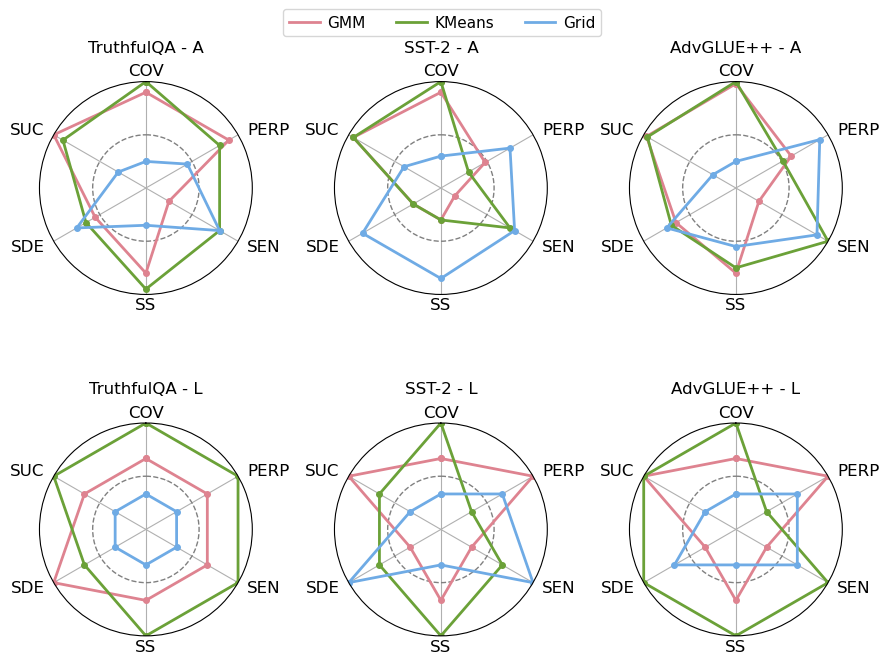

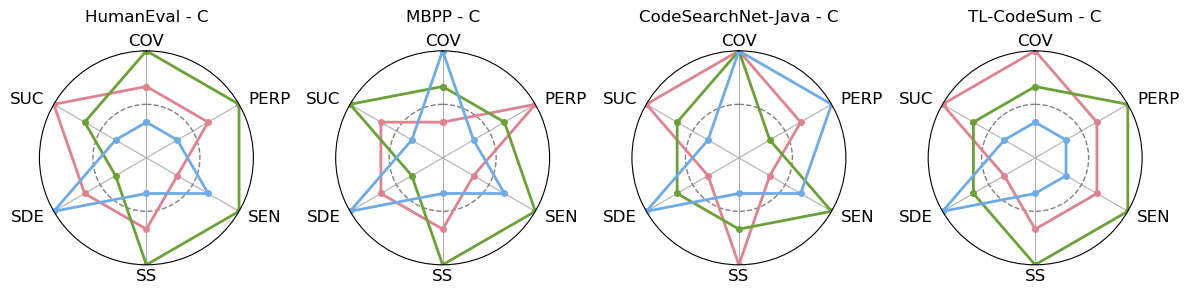

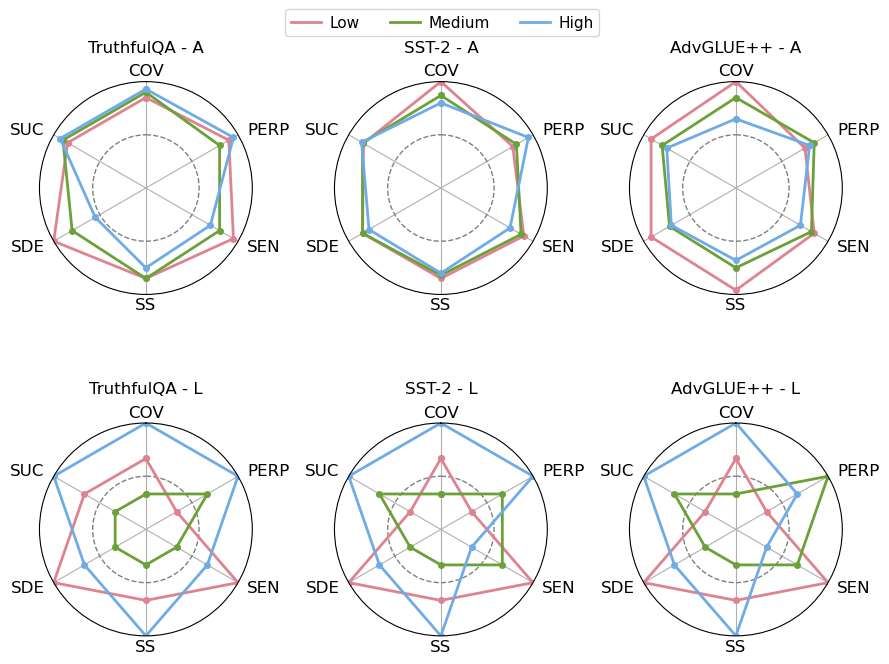

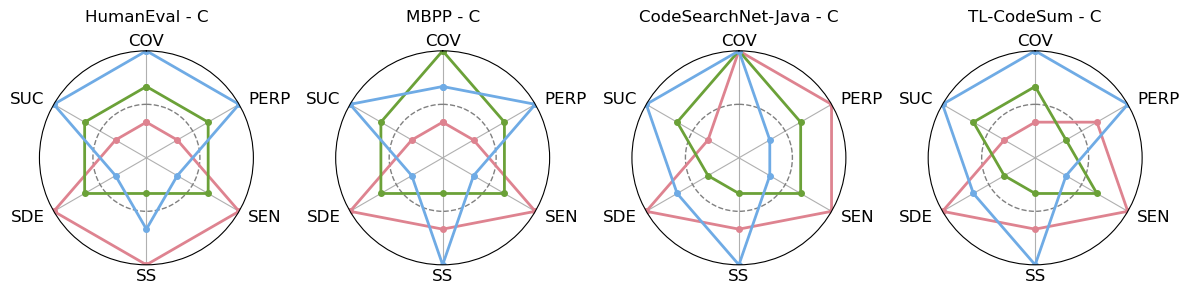

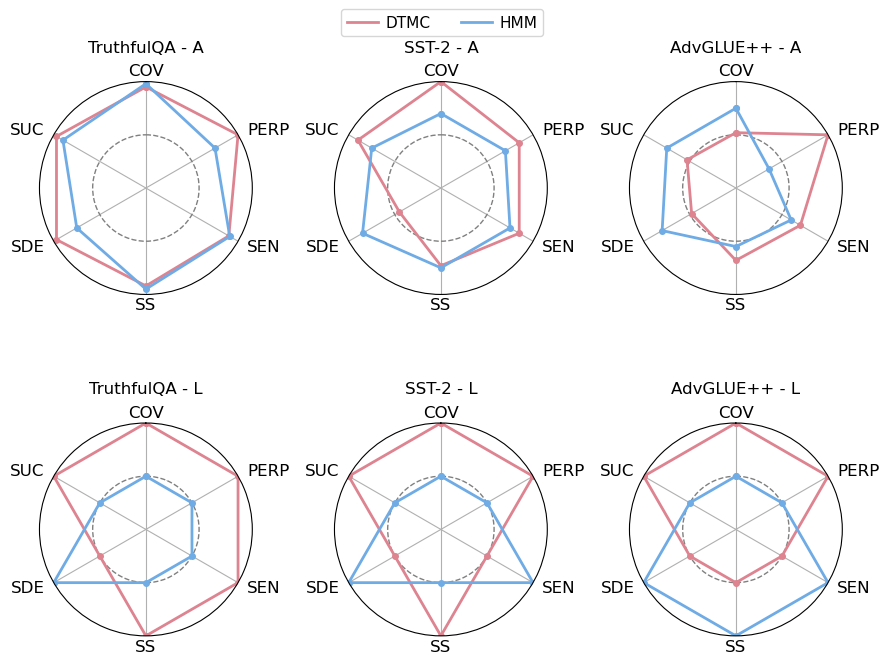

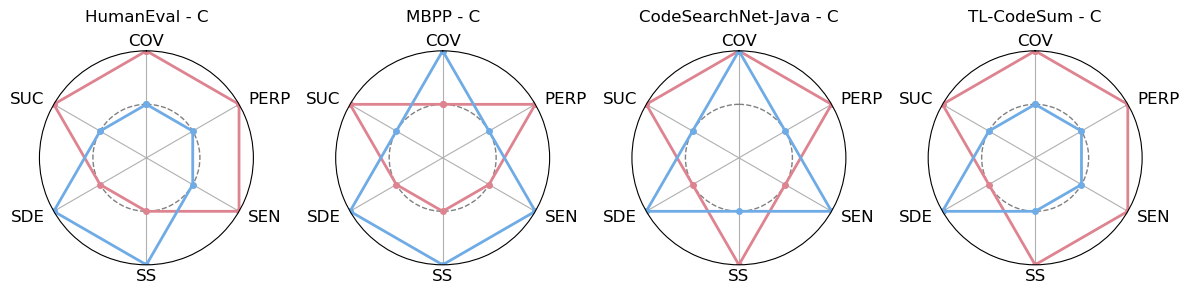

In [29]:
draw_three_rows_plots(abstract_methods_colors, {
    'TruthfulQA - A': alpaca_tqa_abs_method_df,
    'SST-2 - A': alpaca_sst2_abs_method_df,
    'AdvGLUE++ - A': alpaca_adv_abs_method_df,
    
    'TruthfulQA - L': abstract_method_ranked_df_model_truthful_qa,
    'SST-2 - L': abstract_method_ranked_df_model_sst2,
    'AdvGLUE++ - L': abstract_method_ranked_df_model_advglue,
    
    'HumanEval - C': abstract_method_ranked_df_model_humaneval,
    'MBPP - C': abstract_method_ranked_df_model_mbpp,
    'CodeSearchNet-Java - C': abstract_method_ranked_df_model_code_search_net_java,
    'TL-CodeSum - C': abstract_method_ranked_df_model_tl_code_sum,
}, "plot/rq2_abstract_method_nlp.pdf", "plot/rq2_abstract_method_code.pdf")

draw_three_rows_plots(pca_categories_colors, {
    'TruthfulQA - A': alpaca_tqa_pca_df,
    'SST-2 - A': alpaca_sst2_pca_df,
    'AdvGLUE++ - A': alpaca_adv_pca_df,
    
    'TruthfulQA - L': pca_ranked_df_model_truthful_qa,
    'SST-2 - L': pca_ranked_df_model_sst2,
    'AdvGLUE++ - L': pca_ranked_df_model_advglue,
    
    'HumanEval - C': pca_ranked_df_model_humaneval,
    'MBPP - C': pca_ranked_df_model_mbpp,
    'CodeSearchNet-Java - C': pca_ranked_df_model_code_search_net_java,
    'TL-CodeSum - C': pca_ranked_df_model_tl_code_sum,
}, "plot/rq2_pca_nlp.pdf", "plot/rq2_pca_code.pdf")

draw_three_rows_plots(model_type_categories_colors, {
    'TruthfulQA - A': alpaca_tqa_model_type_df,
    'SST-2 - A': alpaca_sst2_model_type_df,
    'AdvGLUE++ - A': alpaca_adv_model_type_df,
    
    'TruthfulQA - L': model_type_ranked_df_model_truthful_qa,
    'SST-2 - L': model_type_ranked_df_model_sst2,
    'AdvGLUE++ - L': model_type_ranked_df_model_advglue,
    
    'HumanEval - C': model_type_ranked_df_model_humaneval,
    'MBPP - C': model_type_ranked_df_model_mbpp,
    'CodeSearchNet-Java - C': model_type_ranked_df_model_code_search_net_java,
    'TL-CodeSum - C': model_type_ranked_df_model_tl_code_sum,
    
}, "plot/rq2_model_type_nlp.pdf", "plot/rq2_model_type_code.pdf")

# RQ3

In [17]:
semantic_metric_rank_ascending_dict = {
    "PRE": True,
    "ENT": True,
    "IVT": False,
    "NVT": False,
    "NDT": True,
    "SL": False,
}

# List of semantic metrics
semantic_metrics = ['PRE', 'ENT', 'IVT', 'NVT', 'NDT', 'SL']

def process_semantic_metrics_dataframe(df_raw):
    df = df_raw.copy()
    # Splitting the 'settings' column into separate columns
    # df['PCA_dim'] = df['PCA_dim'].apply(categorize_pca_dimension)  # Categorize PCA dimensions

    metrics = ['PRE', 'ENT', 'IVT', 'NVT', 'NDT', 'SL']  # Model-wise metrics
    df[metrics] = df[metrics].apply(pd.to_numeric, errors='coerce')  # Convert metrics to numeric
    
    def rank_columns(df, metric_rank_dict):
        ranked_df = pd.DataFrame(index=df.index)
        for metric, ascending in metric_rank_dict.items():
            ranked_df[metric] = df[metric].rank(pct=True, ascending=ascending, method='max')
        return ranked_df

    abstract_semantic_df = df.groupby('abstract_method')[metrics].mean()
    ranked_abstract_semantic_df = rank_columns(abstract_semantic_df, semantic_metric_rank_ascending_dict)

    pca_df = df.groupby('PCA_dim')[metrics].mean()
    ranked_pca_semantic_df = rank_columns(pca_df, semantic_metric_rank_ascending_dict)

    model_type_df = df.groupby('model_type')[metrics].mean()
    ranked_model_type_semantic_df = rank_columns(model_type_df, semantic_metric_rank_ascending_dict)

    return ranked_pca_semantic_df, ranked_abstract_semantic_df, ranked_model_type_semantic_df


In [18]:
# Load your DataFrames
df_semantic_humaneval = mapping_semantic_metrics(humaneval_file_path)
df_semantic_mbpp = mapping_semantic_metrics(mbpp_file_path)
df_semantic_code_search_net_java = mapping_semantic_metrics(code_search_net_java_file_path)
df_semantic_tl_code_sum = mapping_semantic_metrics(tl_code_sum_file_path)

df_semantic_truthful_qa = mapping_semantic_metrics(truthful_qa_file_path)
df_semantic_sst2 = mapping_semantic_metrics(sst2_file_path)
df_semantic_advglue = mapping_semantic_metrics(advglue_file_path)


------- 84
        PRE        ENT       IVT       NVT       NDT        SL
0  0.667411  24.185447  0.291509  1.856668  1.350004  0.231923
1  0.575893  29.439581  0.225823  1.892191  1.361015  0.199551
2  0.658482  33.826567  0.158035  1.884930  0.703256  0.166989
4  0.659598   0.430197  0.448082  2.107808  0.180547  4.017377
7  0.601562   0.550716  0.419869  1.876427  0.253062  3.821907
------- 86
        PRE        ENT       IVT       NVT       NDT        SL
0  0.685065  17.602345  0.179302  1.579897  0.107622  0.263283
1  0.660649  19.150661  0.186457  1.602946  0.044029  0.384398
2  0.693377  21.842690  0.139511  1.675809  0.209856  0.189627
4  0.684481   0.463878  0.363645  1.224820  0.291624  3.868897
5  0.681688   0.279145  0.373791  1.006459  0.026892  3.965352
------- 63
         PRE        ENT       IVT       NVT       NDT        SL
0   0.638975  24.546175  0.085001  2.281604  0.059209  0.288772
4   0.643663   0.688335  0.544684  2.439885  0.167672  2.729583
5   0.655415   0.44

# RQ3.1

In [19]:

# Function to calculate descriptive statistics for aucroc
def calculate_aucroc_stats(df):
    mean_value = df['aucroc'].mean()
    max_value = df['aucroc'].max()
    min_value = df['aucroc'].min()
    median_value = df['aucroc'].median()
    std_dev = df['aucroc'].std()
    variance = df['aucroc'].var()
    return mean_value, max_value, min_value, median_value, std_dev, variance

# Calculate statistics for each DataFrame
humaneval_stats = calculate_aucroc_stats(df_semantic_humaneval)
mbpp_stats = calculate_aucroc_stats(df_semantic_mbpp)
code_search_net_java_stats = calculate_aucroc_stats(df_semantic_code_search_net_java)
tl_code_sum_stats = calculate_aucroc_stats(df_semantic_tl_code_sum)

truthful_qa_states = calculate_aucroc_stats(df_semantic_truthful_qa)
sst2_states = calculate_aucroc_stats(df_semantic_sst2)
adv_states = calculate_aucroc_stats(df_semantic_advglue)

# Print results
print("TruthfulQA Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*truthful_qa_states))
print("SST2 Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*sst2_states))
print("AdvGLUE++ Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*adv_states))
print("HumanEval Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*humaneval_stats))
print("MBPP Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*mbpp_stats))
print("Code Search Net Java Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*code_search_net_java_stats))
print("TL Code Sum Stats: Mean: {}, Max: {}, Min: {}, Median:{}, Std. Dev.: {}, Var.: {}".format(*tl_code_sum_stats))


TruthfulQA Stats: Mean: 0.6385054945054945, Max: 0.6938461538461538, Min: 0.5163736263736264, Median:0.6445604395604394, Std. Dev.: 0.03921464838940384, Var.: 0.001537788648304573
SST2 Stats: Mean: 0.6342683449832531, Max: 0.8460707732634338, Min: 0.5, Median:0.635, Std. Dev.: 0.11510341309512237, Var.: 0.013248795706146387
AdvGLUE++ Stats: Mean: 0.6171626977643082, Max: 0.7952374238762692, Min: 0.5, Median:0.6244969682071939, Std. Dev.: 0.06883122460286087, Var.: 0.00473773748032948
HumanEval Stats: Mean: 0.6882041879251701, Max: 0.9006696428571429, Min: 0.5167410714285714, Median:0.671875, Std. Dev.: 0.10879219271559516, Var.: 0.011835741195867198
MBPP Stats: Mean: 0.6627340682573241, Max: 0.7322077922077923, Min: 0.5390909090909091, Median:0.6706818181818182, Std. Dev.: 0.045334925028811375, Var.: 0.002055255427367948
Code Search Net Java Stats: Mean: 0.6555559215845995, Max: 0.6926166617751877, Min: 0.5330111944991824, Median:0.6641566391346275, Std. Dev.: 0.028969779928188066, Var

In [20]:
def top_5_aucroc_settings(df):
    return df.sort_values(by='aucroc', ascending=False).head(10)[['settings', 'aucroc']]

# Find top 5 settings for each DataFrame
top_5_truthfulqa = top_5_aucroc_settings(df_semantic_truthful_qa)
top_5_sst2 = top_5_aucroc_settings(df_semantic_sst2)
top_5_advglue = top_5_aucroc_settings(df_semantic_advglue)

top_5_humaneval = top_5_aucroc_settings(df_semantic_humaneval)
top_5_mbpp = top_5_aucroc_settings(df_semantic_mbpp)
top_5_code_search_net_java = top_5_aucroc_settings(df_semantic_code_search_net_java)
top_5_tl_code_sum = top_5_aucroc_settings(df_semantic_tl_code_sum)

# Print results
print("Top 5 TruthfulQA Settings:\n", top_5_truthfulqa)
print("Top 5 SST2 Settings:\n", top_5_sst2)
print("Top 5 AdvGLUE++ Settings:\n", top_5_advglue)

print("Top 5 HumanEval Settings:\n", top_5_humaneval)
print("Top 5 MBPP Settings:\n", top_5_mbpp)
print("Top 5 Code Search Net Java Settings:\n", top_5_code_search_net_java)
print("Top 5 TL Code Sum Settings:\n", top_5_tl_code_sum)


Top 5 TruthfulQA Settings:
                      settings    aucroc
112  KMeans_400_1024_DTMC_0_0  0.693846
136  KMeans_600_1024_DTMC_0_0  0.691978
124     GMM_600_1024_DTMC_0_0  0.688242
132   KMeans_600_512_DTMC_0_0  0.687473
104     GMM_400_2048_DTMC_0_0  0.684286
100     GMM_400_1024_DTMC_0_0  0.683846
140  KMeans_600_2048_DTMC_0_0  0.680989
116  KMeans_400_2048_DTMC_0_0  0.680549
84    KMeans_200_512_DTMC_0_0  0.680220
80      GMM_200_2048_DTMC_0_0  0.677912
Top 5 SST2 Settings:
                   settings    aucroc
8    GMM_200_2048_DTMC_0_0  0.846071
132     Grid_15_5_DTMC_0_1  0.834409
121     Grid_15_3_DTMC_0_2  0.830552
32   GMM_400_2048_DTMC_0_0  0.830452
4    GMM_200_1024_DTMC_0_0  0.819791
56   GMM_600_2048_DTMC_0_0  0.816215
133     Grid_15_5_DTMC_0_2  0.815493
110     Grid_10_5_DTMC_0_3  0.810084
120     Grid_15_3_DTMC_0_1  0.809797
0     GMM_200_512_DTMC_0_0  0.808460
Top 5 AdvGLUE++ Settings:
                   settings    aucroc
60      Grid_15_5_DTMC_0_1  0.795237
48

In [21]:
semantic_metric_rank_ascending_dict = {
    "PRE": True,
    "ENT": True,
    "IVT": True,
    "NVT": False,
    "NDT": False,
    "SL": False,
}
semantic_metrics = list(semantic_metric_rank_ascending_dict.keys())

# Function to calculate Pearson correlation coefficients with respect to 'aucroc'
def calculate_correlation(df, metric_rank_dict):
    # Calculate the correlation matrix for the specified metrics plus 'aucroc'
    corr_matrix = df[semantic_metrics + ['aucroc']].corr()

    # Adjust correlation values based on the metric ranking direction
    for metric, ascending in metric_rank_dict.items():
        if not ascending:  # If False, invert the correlation sign for this metric
            corr_matrix[metric]['aucroc'] = corr_matrix[metric]['aucroc'] * -1
            corr_matrix['aucroc'][metric] = corr_matrix['aucroc'][metric] * -1
    
    # Return the correlation with 'aucroc', excluding the 'aucroc' self-correlation
    return corr_matrix['aucroc'].drop('aucroc')

# Calculate correlations for each DataFrame
corr_llama2_truthful_qa = calculate_correlation(df_semantic_truthful_qa, semantic_metric_rank_ascending_dict)
corr_llama2_sst2 = calculate_correlation(df_semantic_sst2, semantic_metric_rank_ascending_dict)
corr_llama2_advglue = calculate_correlation(df_semantic_advglue, semantic_metric_rank_ascending_dict)
correlation_humaneval = calculate_correlation(df_semantic_humaneval, semantic_metric_rank_ascending_dict)
correlation_mbpp = calculate_correlation(df_semantic_mbpp, semantic_metric_rank_ascending_dict)
correlation_code_search_net_java = calculate_correlation(df_semantic_code_search_net_java, semantic_metric_rank_ascending_dict)
correlation_tl_code_sum = calculate_correlation(df_semantic_tl_code_sum, semantic_metric_rank_ascending_dict)

# Display the correlations
print("TruthfulQA Correlations:\n", corr_llama2_truthful_qa)
print("SST2 Correlations:\n", corr_llama2_sst2)
print("AdvGLUE++ Correlations:\n", corr_llama2_advglue)

print("HumanEval Correlations:\n", correlation_humaneval)
print("MBPP Correlations:\n", correlation_mbpp)
print("Code Search Net Java Correlations:\n", correlation_code_search_net_java)
print("TL Code Sum Correlations:\n", correlation_tl_code_sum)

TruthfulQA Correlations:
 PRE    1.000000
ENT    0.519365
IVT   -0.456065
NVT   -0.358067
NDT   -0.295914
SL     0.688902
Name: aucroc, dtype: float64
SST2 Correlations:
 PRE    0.921767
ENT    0.794820
IVT   -0.574650
NVT   -0.520606
NDT   -0.647642
SL     0.882128
Name: aucroc, dtype: float64
AdvGLUE++ Correlations:
 PRE    1.000000
ENT    0.460062
IVT   -0.192588
NVT   -0.486741
NDT   -0.000050
SL     0.573094
Name: aucroc, dtype: float64
HumanEval Correlations:
 PRE    1.000000
ENT    0.770780
IVT   -0.490389
NVT   -0.466617
NDT   -0.231613
SL     0.634130
Name: aucroc, dtype: float64
MBPP Correlations:
 PRE    1.000000
ENT    0.673729
IVT   -0.347619
NVT   -0.497729
NDT   -0.209118
SL     0.781816
Name: aucroc, dtype: float64
Code Search Net Java Correlations:
 PRE    1.000000
ENT    0.579848
IVT   -0.457775
NVT   -0.416406
NDT   -0.219982
SL     0.609919
Name: aucroc, dtype: float64
TL Code Sum Correlations:
 PRE    1.000000
ENT    0.789976
IVT   -0.457270
NVT   -0.667224
NDT   -

In [22]:
model_metrics = ['SUC', 'COV', 'SEN', 'SS', 'PERP', 'SDE']

# Function to calculate Pearson correlation coefficients with respect to 'aucroc'
def calculate_correlation(df):
    return df[model_metrics + ['aucroc']].corr()['aucroc'].drop('aucroc')

# Calculate correlations for each DataFrame
correlation_truthful_qa = calculate_correlation(llama2_df_truthful_qa)
correlation_sst2 = calculate_correlation(llama2_df_sst2)
correlation_advglue = calculate_correlation(llama2_df_advglue)

correlation_humaneval = calculate_correlation(df_model_humaneval)
correlation_mbpp = calculate_correlation(df_model_mbpp)
correlation_code_search_net_java = calculate_correlation(df_model_code_search_net_java)
correlation_tl_code_sum = calculate_correlation(df_model_tl_code_sum)

# Display the correlations
print("TruthfulQA Correlations:\n", correlation_truthful_qa)
print("SST2 Correlations:\n", correlation_sst2)
print("AdvGLUE++ Correlations:\n", correlation_advglue)

print("HumanEval Correlations:\n", correlation_humaneval)
print("MBPP Correlations:\n", correlation_mbpp)
print("Code Search Net Java Correlations:\n", correlation_code_search_net_java)
print("TL Code Sum Correlations:\n", correlation_tl_code_sum)

TruthfulQA Correlations:
 SUC     0.452024
COV     0.368144
SEN    -0.113209
SS     -0.275691
PERP    0.633894
SDE    -0.113685
Name: aucroc, dtype: float64
SST2 Correlations:
 SUC    -0.053322
COV    -0.056080
SEN     0.094031
SS      0.203509
PERP    0.903608
SDE     0.153795
Name: aucroc, dtype: float64
AdvGLUE++ Correlations:
 SUC    -0.125753
COV    -0.296220
SEN     0.140205
SS      0.634191
PERP    0.886937
SDE     0.561341
Name: aucroc, dtype: float64
HumanEval Correlations:
 SUC     0.304587
COV     0.330177
SEN    -0.062969
SS      0.087753
PERP    0.570244
SDE     0.284198
Name: aucroc, dtype: float64
MBPP Correlations:
 SUC    -0.000685
COV    -0.110547
SEN    -0.081535
SS      0.127194
PERP    0.562649
SDE     0.067529
Name: aucroc, dtype: float64
Code Search Net Java Correlations:
 SUC     0.349015
COV          NaN
SEN    -0.050584
SS     -0.156193
PERP    0.365439
SDE     0.174658
Name: aucroc, dtype: float64
TL Code Sum Correlations:
 SUC     0.467758
COV     0.420004
S

## WHY CODESEARCHNET COV are same?

In [23]:

# Function to calculate descriptive statistics for aucroc
def calculate_cov_stats(df):
    mean_value = df['COV'].mean()
    max_value = df['COV'].max()
    min_value = df['COV'].min()
    std_dev = df['COV'].std()
    variance = df['COV'].var()
    return mean_value, max_value, min_value, std_dev, variance

# Calculate statistics for each DataFrame
humaneval_stats_cov = calculate_cov_stats(df_model_humaneval)
mbpp_stats_cov = calculate_cov_stats(df_model_mbpp)
code_search_net_java_stats_cov = calculate_cov_stats(df_model_code_search_net_java)
tl_code_sum_stats_cov = calculate_cov_stats(df_model_tl_code_sum)

# Print results
print("HumanEval Stats: Mean: {}, Max: {}, Min: {}, Std. Dev.: {}, Var.: {}".format(*humaneval_stats_cov))
print("MBPP Stats: Mean: {}, Max: {}, Min: {}, Std. Dev.: {}, Var.: {}".format(*mbpp_stats_cov))
print("Code Search Net Java Stats: Mean: {}, Max: {}, Min: {}, Std. Dev.: {}, Var.: {}".format(*code_search_net_java_stats_cov))
print("TL Code Sum Stats: Mean: {}, Max: {}, Min: {}, Std. Dev.: {}, Var.: {}".format(*tl_code_sum_stats_cov))


HumanEval Stats: Mean: 0.9996507683324031, Max: 1.0, Min: 0.999341672152732, Std. Dev.: 0.00032995764196913586, Var.: 1.0887204549383247e-07
MBPP Stats: Mean: 0.9999999830627272, Max: 1.0, Min: 0.9999998012693324, Std. Dev.: 5.212741648303233e-08, Var.: 2.717267549195511e-15
Code Search Net Java Stats: Mean: 1.0, Max: 1.0, Min: 1.0, Std. Dev.: 0.0, Var.: 0.0
TL Code Sum Stats: Mean: 0.9999775756096116, Max: 1.0, Min: 0.99996, Std. Dev.: 2.0004493084770866e-05, Var.: 4.001797435786455e-10
